In [18]:
import pandas as pd
import numpy as np
import scipy as sp
import sklearn
import seaborn as sns
from matplotlib import pyplot as plt
import sklearn.cross_validation
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
#because dataset is skewed we can try out logistic regression with balanced weights
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc, classification_report, confusion_matrix

In [7]:
%pylab inline

import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.cross_validation import train_test_split

try:
    from sklearn.preprocessing import PolynomialFeatures
    from sklearn.pipeline import make_pipeline
except ImportError:
    # use backports for sklearn 1.4
    # available from https://s3.amazonaws.com/datarobotblog/notebooks/sklearn_backports.py
    from sklearn_backports import PolynomialFeatures
    from sklearn_backports import make_pipeline

# ignore DeprecateWarnings by sklearn
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

Populating the interactive namespace from numpy and matplotlib


In [3]:
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(df_train.SeriousDlqin2yrs))
    plt.xticks(tick_marks, df_train.SeriousDlqin2yrs, rotation=45)
    plt.yticks(tick_marks, df_train.SeriousDlqin2yrs)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [4]:
df_train=pd.read_csv('train_ireg_amd_dmd.csv')
df_test=pd.read_csv('test_ireg_amd_dmd.csv')

In [24]:
df_train.head(10)

,Unnamed: 0,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,0,1,0.766127,45,2,0.802982,9120.000000,13,0,6,0,2.0
1,1,0,0.957151,40,0,0.121876,2600.000000,4,0,0,0,1.0
2,2,0,0.658180,38,1,0.085113,3042.000000,2,1,0,0,0.0
3,3,0,0.233810,30,0,0.036050,3300.000000,5,0,0,0,0.0
4,4,0,0.907239,49,1,0.024926,63588.000000,7,0,1,0,0.0
5,5,0,0.213179,74,0,0.375607,3500.000000,3,0,1,0,1.0
6,6,0,0.305682,57,0,5710.000000,8738.957438,8,0,3,0,0.0
7,7,0,0.754464,39,0,0.209940,3500.000000,8,0,0,0,0.0
8,8,0,0.116951,27,0,46.000000,3045.627787,2,0,0,0,1.0
9,9,0,0.189169,57,0,0.606291,23684.000000,9,0,4,0,2.0


In [26]:
#Currently getting subset of data and just wrangling around and trying

Y_train=np.array(df_train.SeriousDlqin2yrs)
#features = ['RevolvingUtilizationOfUnsecuredLines', 'DebtRatio',
#            'MonthlyIncome', 'age', 'NumberOfTimes90DaysLate']
features=['RevolvingUtilizationOfUnsecuredLines','age','NumberOfTime30-59DaysPastDueNotWorse','DebtRatio','MonthlyIncome','NumberOfOpenCreditLinesAndLoans','NumberOfTimes90DaysLate','NumberRealEstateLoansOrLines','NumberOfTime60-89DaysPastDueNotWorse','NumberOfDependents']
X_train=np.array(df_train[features])

In [27]:
X_train, X_validation, Y_train, Y_validation = train_test_split(X_train, Y_train, test_size=0.25)

In [28]:
#need cross validation to decide
seed = np.random.seed(12345)
logisticmodel_reg = LogisticRegressionCV(Cs=[100],cv=5,penalty='l1', class_weight='auto',solver='liblinear',scoring='roc_auc') 

In [29]:
logisticmodel_reg.fit(X_train,Y_train)

LogisticRegressionCV(Cs=[100], class_weight='auto', cv=5, dual=False,
           fit_intercept=True, intercept_scaling=1.0, max_iter=100,
           multi_class='ovr', n_jobs=1, penalty='l1', refit=True,
           scoring='roc_auc', solver='liblinear', tol=0.0001, verbose=0)

In [30]:
pred_logisticmodel=logisticmodel_reg.predict_log_proba(X_validation)

In [38]:
pclass=logisticmodel_reg.predict(X_validation)

In [31]:
roc_auc_score(Y_validation,pred_logisticmodel[:,1])

0.79715469988423648

In [39]:
print classification_report(np.array(Y_validation),np.array(pclass))

             precision    recall  f1-score   support

          0       0.97      0.78      0.86     35008
          1       0.17      0.66      0.28      2492

avg / total       0.92      0.77      0.82     37500



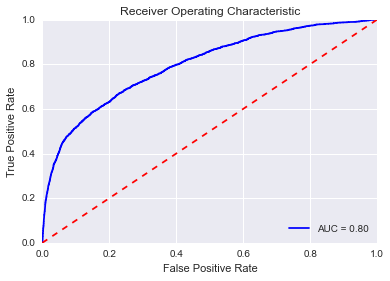

In [41]:
preds = pred_logisticmodel[:,1]
fpr, tpr, threshold = roc_curve(Y_validation, preds)
roc_auc = auc(fpr, tpr)

# method I: plt
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

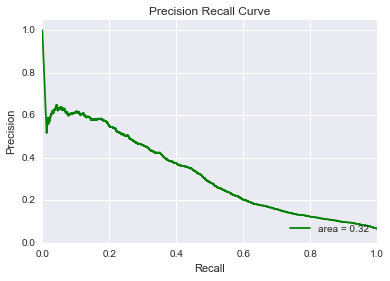

In [40]:
precision, recall, _ = precision_recall_curve(Y_validation, preds, pos_label=1)
average_precision = average_precision_score(Y_validation, preds)
plt.plot(recall, precision, label='area = %0.2f' % average_precision, color="green")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision Recall Curve')
plt.legend(loc="lower right")
plt.show()

In [34]:
features=['RevolvingUtilizationOfUnsecuredLines','age','NumberOfTime30-59DaysPastDueNotWorse','DebtRatio','MonthlyIncome','NumberOfOpenCreditLinesAndLoans','NumberOfTimes90DaysLate','NumberRealEstateLoansOrLines','NumberOfTime60-89DaysPastDueNotWorse','NumberOfDependents']
X_test=np.array(df_test[features])

In [35]:
pred_test=logisticmodel_reg.predict_proba(X_test)[:,1]

In [36]:
idx=np.arange(1,len(pred_test)+1,1)
print len(pred_test)

#output=np.array()
#output=np.zeros((len(pred_test),2))
#output[:,0]=idx
#output[:,1]=pred_test
output=pd.DataFrame(pred_test)
dfoutput=pd.DataFrame(output)
dfoutput['Id']=idx
dfoutput['Probability']=dfoutput[0]
del dfoutput[0]
dfoutput


101503


,Id,Probability
0,1,0.408951
1,2,0.391204
2,3,0.355328
3,4,0.620417
4,5,0.556310
5,6,0.297576
6,7,0.439112
7,8,0.326572
8,9,0.243175
9,10,1.000000


In [37]:
dfoutput.to_csv('pred2.csv',index=False)